# Tutorial on acoustic reverse-time migration

## Forward modeling

In [2]:
from __future__ import division
import numpy as np
from bruges.filters.wavelets import ricker
import matplotlib.pyplot as plt
from scipy.signal import convolve
import skimage.filters
#import skimage.io

Setup framework parameters

In [3]:
dt = 1e-4 #seconds
dx = 1    #meters
dz = 1    #meters

#Size of model in meters
nx = 100
nz = 80

tmax = 0.1 #seconds
t_array = np.arange(0, tmax, dt) #array of times

Setup velocity model

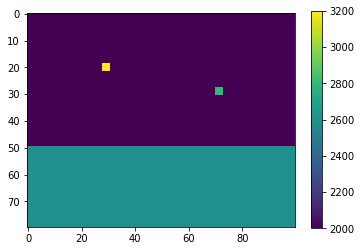

In [4]:
vp = 2000.0     #m/s
vmodel = vp * np.ones((nx, nz), dtype = float)

vmodel[:, 50:] = vp*1.3
vmodel[70:73, 28:31] = vp*1.4
vmodel[28:31, 19:22] = vp*1.6

im_v = plt.imshow(vmodel.T)
plt.colorbar()
plt.show()


Create a wavelet

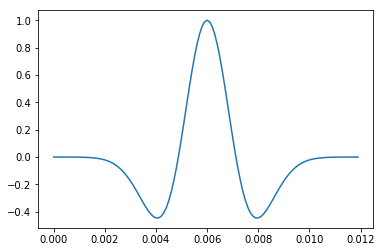

In [5]:
wav1 = ricker(duration = 0.012, dt = dt, f = 200)
plt.plot(np.arange(0, 0.012, dt), wav1)
plt.show()

Set source position

In [6]:
isx = 50
isz = 0

Now ready to do 2d FDTD acoustic modeling.


Detailed info about programming a FD solution to 1D wave equation can be found at [This document](w3.pppl.gov/m3d/1dwave/ln_fdtd_1d.pdf)


Let $u(x, z, t)$ be wave amplitude. $u(x, z, t_k)$ means a wavefield snapshot at time $t_k$. In this acoustic case $u$ corresponds to pressure

If $x_n$ is $n \Delta x$, $z_m$ is $m \Delta z$, $t_k$ is $k \Delta t$, then let's write $u(x_n, z_m, t_k)$ as $u_{m,n}^k$

Since 2D wave equation can be written as 
$$ \frac{\partial^2{u(x,t)}}{\partial{x^2}} = \frac{1}{c^2} \frac{\partial^2{u(x,t)}}{\partial{t^2}} , $$

and we can replace partial derivatives by simple differences, it all leads to

$$ u_{m,n}^{k+1} = r^2 \left(u_{m+1,n}^k + u_{m,n+1}^k - 4u_{m,n}^k + u_{m-1,n}^k + u_{m,n-1}^k \right) +2u_{m,n}^k - u_{m,n}^{k-1} ,$$ 
where $r = c \Delta t / \Delta x$

Now, this simply means that to find $u$ on step $k+1$ in a certain point $(x_n, z_m)$, we need to sum and multiply $u$ values at 5 points at step $k$ and 1 point at step $k-1$. This means that u can be calculated step-by-step for every time from start-time `t0 + 2*dt` to end-time `tmax`. To calculate $u_{m,n}^{2}$, we need to have values of $u_{m,n}^{1}$ and $u_{m,n}^{0}$ already pre-calculated or simply given. This is called *initial conditions*. In this example, we will set them to all-zeros.

    

Let `u_all` be a 3-D array of wave amplitude

For now, fill it with zeros.

In [7]:
u_all = np.zeros((np.shape(vmodel)[0], np.shape(vmodel)[1], int(tmax/dt)), dtype = float)

r = vmodel*dt/dx

The value in brackets combines five values at time $k$ with different weights ![Image](https://source.ggy.bris.ac.uk/uploads/thumb/4/4d/Five-point-stencil.jpg/200px-Five-point-stencil.jpg)

computing this combination for every point in 2-d space can be done by 2D convolution with operator 
$$ D = \left\lgroup \matrix{ 0 & 1 & 0 \cr 1 & -4 & 1 \cr 0 & 1 & 0} \right\rgroup $$

Thus, we can write this pseudo-code for wavefield computation:

1. Set initial conditions at first two moments of time: $u_0$, $u_1$
2. For every $k$-th step from 2 till last:
   - convolve $u_{k-1}$ with operator $D$
   - multiply it point-by-point by $r$ and add $2u_{m,n}^k - u_{m,n}^{k-1}$
   - add source amplitude to $u$ at point `[isx, isz]`
   
For convenience, let's create a function `solve_fd2d` to perform computations that are repeated at every step:

In [8]:
def solve_fd2d(v, w, vmodel, r, dt, dx, dz):
    """
    Compute wave amplitude at the next k-th time step
    v = snapshot of amplitude at last step (k-1)
    w = snapshot of amplitude at previous step (k-2).
    """
    
    D = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    
    return 2*v - 1*w + (r**2)*convolve(v, D, mode='same')

In [9]:
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_all[:,:,k-1]
        w = u_all[:,:,k-2]
        
        u = solve_fd2d(v, w, vmodel, r, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_all[:,:,k] = u


Voila! Yes, it's **that** simple. We made it with a dozen lines of code.
Let's take a look the results.

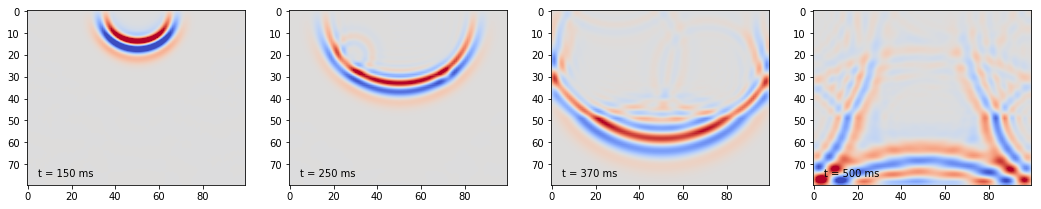

In [10]:
iterations_to_show = [150, 250, 370, 500]
fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
for j, ax in enumerate(axs):
    ax.imshow(u_all[:, :, iterations_to_show[j]].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

You can see clearly what is not good with this simulation, can you? Yes, those boundary reflections. Fortunately, there are many ways to eliminate them by using special boundary conditions. For this example, we are going to use absorbing boundary conditions (ABC).

It can be shown that (for right boundary $x = x_N$):

$$u_{N, m}^{k+1} = u_{N-1, m}^{k} + \frac{r-1}{r+1} \left( u_{N-1, m}^{k+1} - u_{N, m}^{k} \right) $$

Similarly, for left boundary:

$$u_{0, m}^{k+1} = u_{1, m}^{k} + \frac{r-1}{r+1} \left( u_{1, m}^{k+1} - u_{0, m}^{k} \right) $$

and bottom boundary:

$$u_{n, M}^{k+1} = u_{n, M-1}^{k} + \frac{r-1}{r+1} \left( u_{n, M-1}^{k+1} - u_{n, M}^{k} \right) $$

To implement them, we need to modify the wavefield at the bottom, left and right boundaries at every time step.
Better to make it in a new function, `solve_fd2d_abc`:

In [11]:
def solve_fd2d_abc(v, w, vmodel, r, dt, dx, dz):
    """
    Compute wave amplitude at the next k-th time step
    with boundary conditions
    
    v = snapshot of amplitude at last step (k-1)
    w = snapshot of amplitude at previous step (k-2).
    """
    
    D = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    u_out = 2*v - 1*w + (r**2)*convolve(v, D, mode='same')
    
    #bottom
    u_out[:,-1] = v[:,-2] + (r[:,-1] - 1)/(r[:,-1] + 1)*(u_out[:,-2] - v[:,-1])
    #right
    u_out[-1,:] = v[-2,:] + (r[-1,:] - 1)/(r[-1,:] + 1)*(u_out[-2,:] - v[-1,:])
    #left
    u_out[0,:] = v[1,:] + (r[0,:] - 1)/(r[0,:] + 1)*(u_out[1,:] - v[0,:])
    
    return u_out

In [12]:
u_abc = np.zeros((np.shape(vmodel)[0], np.shape(vmodel)[1], int(tmax/dt)), dtype = float)
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_abc[:,:,k-1]
        w = u_abc[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel, r, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_abc[:,:,k] = u


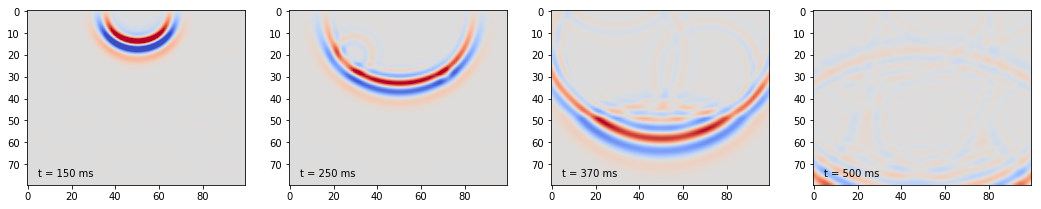

In [13]:
fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
for j, ax in enumerate(axs):
    ax.imshow(u_abc[:, :, iterations_to_show[j]].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

Oh, wow.

Displaying common-shot gathers is as simple as showing $u(x,0,t)$:

In [14]:
surface_record_no_bc = u_all[:,1,:]
surface_record_raw = u_abc[:,1,:]

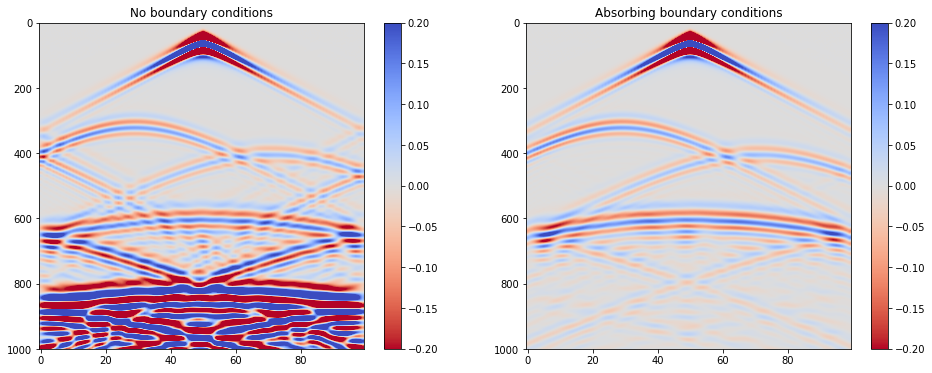

In [15]:
#display

fgr2, axs2 = plt.subplots(1,2, figsize = (16,6))
im1=axs2[0].imshow(surface_record_no_bc.T, cmap = 'coolwarm_r', vmin = -0.2, vmax = 0.2, interpolation='bilinear', aspect='auto')
im2=axs2[1].imshow(surface_record_raw.T, cmap = 'coolwarm_r', vmin = -0.2, vmax = 0.2, interpolation='bilinear', aspect='auto')
axs2[0].set_title('No boundary conditions')
axs2[1].set_title('Absorbing boundary conditions')
fgr2.colorbar(im1, ax = axs2[0])
fgr2.colorbar(im2, ax = axs2[1])
plt.show()

We can clearly see a reflected wave (at 600 - 700 ms) and two diffracted waves on this gather.

There are still boundary reflections, but they have become significantly weaker. Further improvement can be achieved by using more complex boundary conditions, such as perfectly matched layer (PML).

## Gather conditioning

**Top muting** is performed in 2 steps: 
1. Compute traveltimes of direct wave t = x/v; 
2. Set values of the gather to 0 for recording times less than t computed at step 1

Spherical divergence is not applied here

In [16]:
#Top muting
muted_gather = surface_record_raw.copy()
x_array = np.arange(0, nx*dx, dx)
v0 = vmodel[:,0]
traveltimes = abs(np.cumsum(dx/v0) - np.cumsum(dx/v0)[isx])
for traceno in xrange(len(x_array)):
    muted_gather[traceno, 0:int(traveltimes[traceno]/dt  + len(wav1))] = 0 
    

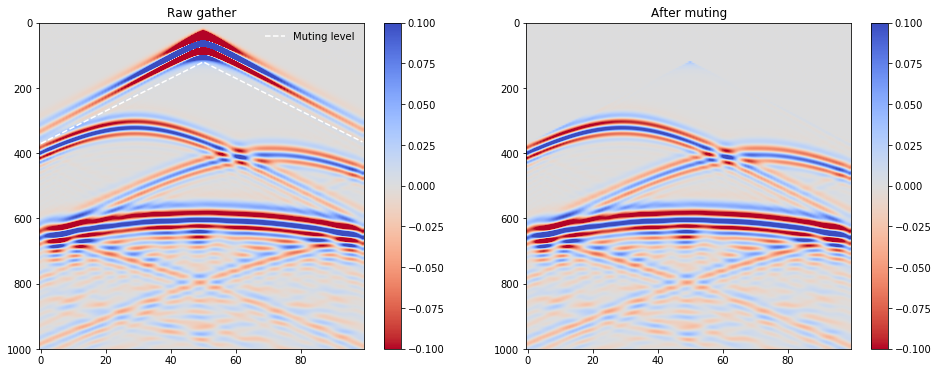

In [17]:
#display
fgr3, axs3 = plt.subplots(1, 2, figsize = (16,6))

axs3[0].set_title('Raw gather')
im3=axs3[0].imshow(surface_record_raw.T, cmap = 'coolwarm_r', vmin = -0.1, vmax = 0.1, interpolation='bilinear', aspect='auto')
axs3[0].plot(traveltimes/dt  + len(wav1), c='w', ls='--', label = 'Muting level')
axs3[0].legend(framealpha = 0.0)
fgr3.colorbar(im3, ax = axs3[0])

axs3[1].set_title('After muting')
im4=axs3[1].imshow(muted_gather.T, cmap = 'coolwarm_r', vmin = -0.1, vmax = 0.1, interpolation='bilinear', aspect='auto')
fgr3.colorbar(im4, ax = axs3[1])

plt.show()

## Migration

As perfectly explained in Etienne Robein's [Seismic Imaging: A Review of the Techniques, their Principles, Merits and Limitations](http://bookshop.eage.org/Webshop/product_details.aspx?prod_code=AA0172), the workflow of reverse time migration consists of three general steps:
1. **Compute and store snapshots of the downgoing wavefield**: this is exactly the same procedure as we have done previously.  The only difference is that we pretend not to know the exact velocity model. Therefore, we use smoothed velocidy field for modeling, assuming that it is the result of velocity model building.
2. **Compute and store snapshots of the up-going wavefield in reversed time domain**: this step is also very similar to what we have done before, except for the fact that *gather acts as source*. This can be thought of as like we reconstruct the wavefield that has arrived to receivers step-by step, from the end to beginning. 
3. **Cross-correlate up-going and down-going wavefields** at avery point (x,z) of the image. The value at zero-lag should represent the reflectivity at this point of model.


Personally, I always show [this animation](https://www.geo.uni-hamburg.de/en/geophysik/forschung/wissenschaftliche-animationen/pre-stack-reverse-time.html) when explaining RTM to someone:
![](https://www.geo.uni-hamburg.de/5607962/rtm-anim-0c59d6a2273e527fc56cd48afb2f4ab791f9221e.gif)

The first animation (top-left) corresponds to step 1: this is formard modeling in a smoothed velocity model. True velocity model is shown as greenish background, but we see no reflected waves due to the smoothness of velocity field.

The second animation (top-right) illustrates step 2. There is no point-source now, but instead of it the whole surface acts as a source of seismic waves, and the amplitudes of this source are given by the recorded gather. The modeling is performed in *reversed time*, which means that gather is 'read' from the end to the beginning. To display it simultaneously along with the first animation, it is played backwards.

The third animation (bottom) is a result of cross-correlating upgoing and downgoing wavefiels. It illustrates Claerbout's [*Imaging principle*](https://wiki.seg.org/wiki/Dictionary:Imaging_principle/en):
>reflectors exist at points in the ground where the first arrival of the downgoing wave is time-coincident with an upgoing wave

Part of the image that is constructed at current time step is highlighted in red.

#### 1. Computing the downgoing (source) field

Smooth the velocity field with a gaussian kernel:

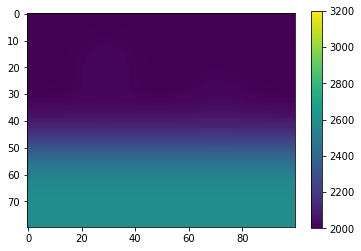

In [18]:
vmodel_smooth = skimage.filters.gaussian(vmodel, 9)
r_smooth = vmodel_smooth*dt/dx

#display
plt.imshow(vmodel_smooth.T, vmin = im_v.get_clim()[0], vmax = im_v.get_clim()[1]) #use same color scale as for the first image of original model
plt.colorbar()
plt.show()

Forward modeling is done exactly the same as before, the only difference is smoothed velocity model

In [19]:
u_down = np.zeros((np.shape(vmodel_smooth)[0], np.shape(vmodel_smooth)[1], int(tmax/dt)), dtype = float)
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_down[:,:,k-1]
        w = u_down[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel_smooth, r_smooth, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_down[:,:,k] = u

#### 2. Computing the upgoing (receiver) field

In [20]:
u_up = np.zeros((np.shape(vmodel_smooth)[0], np.shape(vmodel_smooth)[1], int(tmax/dt)), dtype = float)
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_up[:,:,k-1]
        w = u_up[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel_smooth, r_smooth, dt, dx, dz)
        
        # Instead of source, add amplitudes of the recorded gather
        u[:, 0] = u[:, 0] + muted_gather[:,-(k-1)]

        u_up[:,:,k] = u

#### 3. Computing the final image with cross-correlation

In [21]:
migrated_image = np.zeros_like(u_up[:,:,0], dtype = float)
for i in xrange(np.shape(migrated_image)[0]):
    for j in xrange(np.shape(migrated_image)[1]):
        migrated_image[i, j] = np.sum(u_up[i, j, :]*u_down[i, j, ::-1])

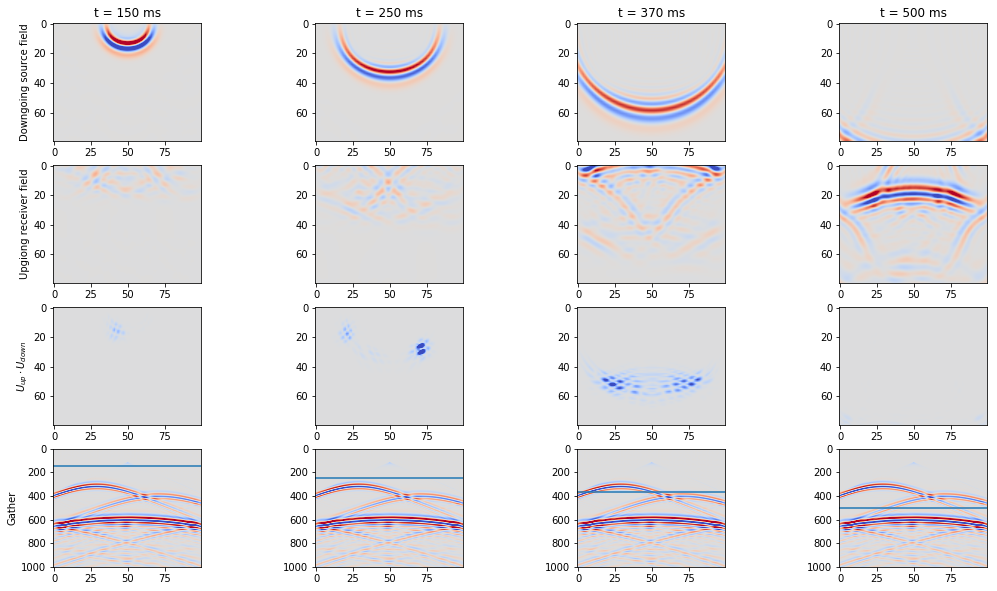

In [29]:
#display

fgr4, axs4 = plt.subplots(4,len(iterations_to_show), figsize = (18,10))

for j, t_iter in enumerate(iterations_to_show):
    axs4[0,0].set_ylabel("Downgoing source field")
    axs4[0,j].set_title("t = {0} ms".format(t_iter))
    axs4[0,j].imshow(u_down[:, :, t_iter].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear', aspect = 1)
    axs4[1,0].set_ylabel("Upgiong receiver field")
    axs4[1,j].imshow(u_up[:, :, t_iter].T, cmap = 'coolwarm_r', vmin = -4, vmax = 4, interpolation='bilinear', aspect = 1)
    axs4[2,0].set_ylabel(r"$U_{up} \cdot U_{down}$")
    axs4[2,j].imshow(abs((u_up[:, :, -t_iter].T * u_down[:, :, t_iter].T)), cmap = 'coolwarm_r', vmin = -2, vmax = 2, interpolation='bilinear', aspect = 1)
    axs4[3,0].set_ylabel("Gather")
    axs4[3,j].imshow(muted_gather.T, cmap = 'coolwarm_r', vmin = -0.1, vmax = 0.1, interpolation='bilinear', aspect = nz/(tmax/dt))
    axs4[3,j].axhline(t_iter)
plt.show()

Probably it's more clear when animated:
![](https://github.com/antongrin/rtm-migration-tutorial/blob/master/rtm_animation.gif?raw=true)

Let's finally display the result image

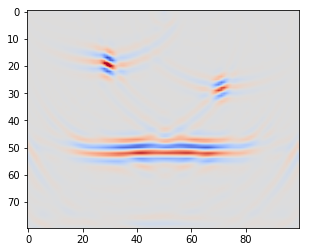

In [23]:
plt.imshow(migrated_image.T,cmap = 'coolwarm_r', vmin = -150, vmax = 150, interpolation='bilinear')
plt.show()

This nice image is a result of migration of a single shot! 

If there were more shots, the final image would be constructed by averaging of many single-shot images. It would have a higher signal-to-noise ratio and cover the whole model, not only its central part.